# Tutorial Basics Noten Part 2: Statistik

Inhaltsverzeichnis: 

1. Abfrage von einfachen statistischen Angaben
2. Häufigkeiten:
            2.1 Tonhöhen
            2.2 Tonhöhenklassen
            2.3 Intervalle
            2.4 Tondauern
            2.5 Metrisches Profil
3. Zweidimensionale Häufigkeitsverteilungen
4. Aufgaben

Dieses Tutorial führt anhand von Notenbeispielen in die computergestützten Möglichkeiten einfacher statistischer Abfragen auf der Grundlage von CAMAT (Computer-Assisted Music Analysis Tool) ein. 

Das Durcharbeiten und Nachvollziehen des Tutoriums soll es Ihnen ermöglichen, mit den vorgestellten computergestützten Methoden eigene Musikbeispiele (Notendateien) zu untersuchen und Vergleiche zwischen verschiedenen Musikstücken durchzuführen. 

Jeder Start eines Jupyter Notebooks beginnt mit dem Import einer Reihe von Python-Bibliotheken, die für die Analyse erforderlich sind:  

In [1]:
import sys
import os
sys.path.append(os.getcwd().replace(os.path.join('music_xml_parser', 'ipynb'), ''))
import music_xml_parser as mp
from music21 import * 
import csv
from IPython.display import HTML, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mit diesen Befehlen wird nicht nur der CAMAT music_xml_parser, 
# sondern darüber hinaus die Bibliotheken 'numpy' und 'pandas' für statische Auswertungen, 
# 'music21' sowieund 'matplotlib' für grafische Darstellungen geladen. 

# Mit den folgenden Befehlen wird die Formtierung für die Tabellen festgelegt, 
# die weiter unten dargestellt werden - '9999' ist der Maximalwert: 

pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', 9999)
pd.set_option('display.width', 9999)
    
environment.set('autoDownload', 'allow')
# Hierdurch wird der Download von xml-Dateien aus dem Internet ermöglicht. 

Anschließend müssen Sie die Datei laden, die Sie untersuchen wollen (aus dem Internet oder von Ihrer Festplatte bzw. aus dem Notenordner) und den xml-parser aktivieren. Dabei wird aus der xml-Datei ein neuer dataframe ('m_df') erzeugt, der den folgenden statistischen Abfragen zugrunde liegt. 

Wir wählen für unser Tutorial als Beispiel den ersten Satz aus dem Streichquartett KV. 171 von Wolfgang Amadeus Mozart. 

In [2]:
xml_file = 'https://analyse.hfm-weimar.de/database/03/MoWo_K171_COM_1-4_StringQuar_003_00867.xml'

m_df = mp.parse.with_xml_file(file=xml_file,
                                    save_file_name=None,
                                    do_save=False)

# Mit dem Befehl wird hieraus ein Pandas-Dataframe (mit der Bezeichnung 'm_df') erzeugt.
# Zur Einstellung der Parameter vgl. Sie bitte das Tutorial_Part1_Introduction.

### 1. Abfrage von einfachen statistischen Angaben

Wir beginnen mit einfachen statistischen Abfragen der Anzahl der Stimmen, der Länge in Takten, der Anzahl der Töne (insgesamt und pro Stimmen) und dem Ambitus der einzelnen Stimmen. 

Bitte öffnen Sie die Notendatei parallel in Ihrem Noteneditor (z.B. MuseScore). 

Achtung: Da mit dem ersten Auswertungsbefehl die Daten erstmals eingelesen werden, braucht die Ausführung erfahrungsgemäß relativ lange (abhängig von Ihrem Computer und der Dateigröße bis zu mehreren Minuten). Alle späteren Befehle gehen dann aber sehr rasch!!

In [3]:
v = m_df[['PartID','PartName']].drop_duplicates().to_numpy()
mp.utils.display_table(data=v, 
                       columns=['Part ID', 'Part Name'])

# In der ersten Befehlszeile werden aus der dataframe-Liste des xml-Parser ('m_df')
# die PartIDs und PartNames, # also die IDs und Bezeichnungen der einzelnen Stimmen, abgefragt. 
# Hierfür wird die Variable 'v' vergeben.
# In der zweiten Zeile werden die Spaltenüberschriften der Tabelle festgelegt. 

# ACHTUNG: Ist in einer MusicXML-Datei keine Stimmbezeichnung festgelegt, 
# so kann diese hier natürlich auch nicht dargestellt werden ('None')!

Part ID,Part Name
1,Violino I
2,Violino II
3,Viola
4,Violoncello


In [4]:
m = m_df['Measure'].to_numpy(dtype=int)
max(m)
# Abfrage der Stückänge in Takten.

159

In [5]:
n_notes, c_notes = np.unique(m_df['PartName'], return_counts=True)
data = [[i, c] for i, c in zip(n_notes, c_notes) ]
mp.utils.display_table(data=data, 
                       columns=['Part Name', 'Notenanzahl'])
 
# Abfrage der Anzahl der Töne per Stimme, 
# wobei übergebundene Noten jeweils als eine Note gezählt werden. 
# Falls die Stimmen in der xml-Datei keine Bezeichnungen besitzen, 
# so muss 'PartName' (und 'Part Name') durch 'PartID' ersetzt werden! 

Part Name,Notenanzahl
Viola,382
Violino I,576
Violino II,626
Violoncello,385


In [6]:
ambitus = mp.analyse.ambitus(m_df,
                             output_as_midi=True)

mp.utils.display_table(data=ambitus, 
                       columns=['Part ID', 'PartName', 'min', 'max', 'Ambitus'])

# Der Ambitus per Stimme wird in Halbtonschritten angegeben. 
# Er errechnet sich aus der Differenz zwischen 
# dem niedrigsten (min) und höchsten (max) Ton, 
# hier angegeben in MIDI-Werten 
# mit c' = C4 = 60; c'' = C5 = 72 usw. 

Part ID,PartName,min,max,Ambitus
1,Violino I,57,87,30
2,Violino II,55,82,27
3,Viola,48,75,27
4,Violoncello,39,67,28


In [7]:
# Durch den Zusatz 'output_as_midi=False' werden die Töne mit Tonnamen angegeben. 

ambitus = mp.analyse.ambitus(m_df,
                             output_as_midi=False)

mp.utils.display_table(data=ambitus, 
                       columns=['Part ID', 'PartName', 'min', 'max', 'Semitones Difference'])


Part ID,PartName,min,max,Semitones Difference
1,Violino I,A3,D#6,30
2,Violino II,G3,A#5,27
3,Viola,C3,D#5,27
4,Violoncello,D#2,G4,28


### 2. Häufigkeiten

Zur Charakterisierung einzelner Musikstücke und zum Vergleich zwischen verschiedenen Musikstücken kann es sinnvoll sein, die Häufigkeit bestimmter Elemente (Tonhöhen, Notendauern etc.) zu bestimmen. Für solche Fragen lassen sich Häufigkeitstabellen und grafische Darstellungen, sog. Histogramme, erstellen. 

### 2.1 Tonhöhen

Welche Töne tauchen wie häufig auf? Wie diatonisch ist der Tonraum der Komposition, wie viele zusätzliche chromatische Töne tauchen auf?

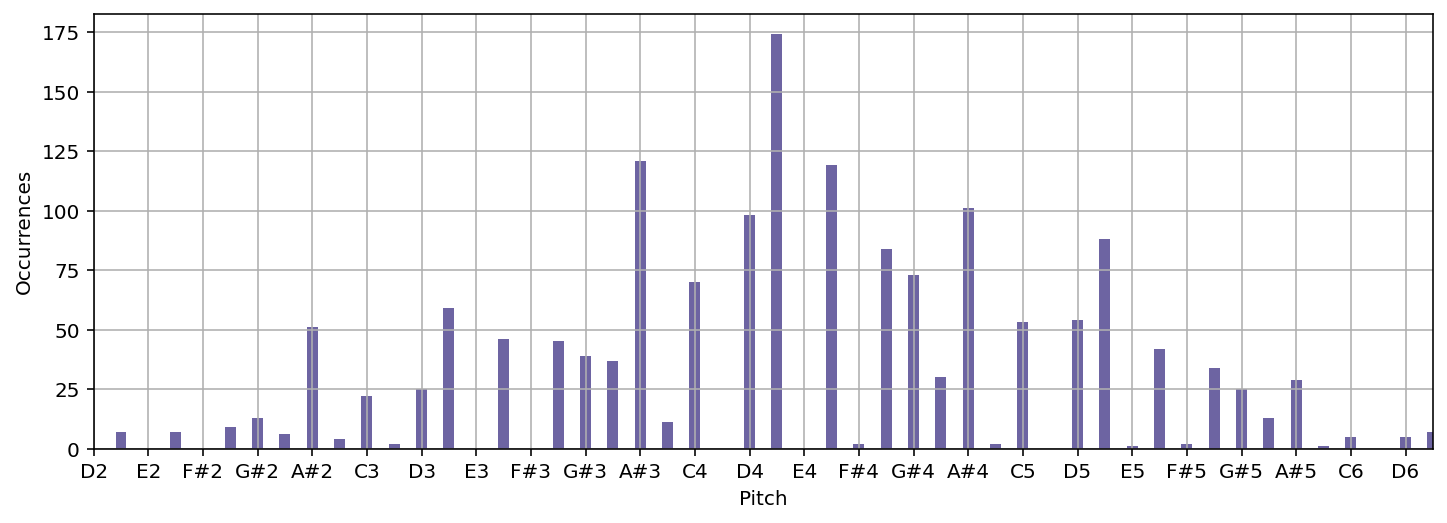

In [8]:
pitch_hist = mp.analyse.pitch_histogram(m_df, 
                                        do_plot=True, 
                                        visulize_midi_range=None)

# Mit der ersten Zeile wird aus 'm_df' eine Histogrammdarstellung mit dem Namen 'pitch_hist' erzeugt. 
# Durch den Parameter 'do_plot=True' wird die Grafik dargestellt. 
# Durch 'visulize_midi_range=None' wird eine Tabellendarstellung (s. unten) verhindert. 

Was können wir erkennen?

Mozart verwendet in der Komposition anscheinend hauptsächlich Töne der Es-Dur-Tonleiter (es=D#, as=G#, b=a# usw.) und kaum chromatische Töne. 

Wir wollen nun genau wissen, wie häufig die einzelnen Töne auftauchen! 

In [9]:
# Die Häufigkeitstabelle wird erzeugt, wenn wir die Parameter umstellen: 
# 'do_plot=None' und 'visulize_midi_range=True'.

pitch_hist = mp.analyse.pitch_histogram(m_df, 
                                        do_plot=None, 
                                        visulize_midi_range=True)

mp.utils.display_table(data=pitch_hist, 
                       columns=['MIDI', 'Pitch','Occurences'])

# Mit dem zweiten Befehl wird die Tabelle dargestellt und beschriftet. 

MIDI,Pitch,Occurences
39,D#2,7
41,F2,7
43,G2,9
44,G#2,13
45,A2,6
46,A#2,51
47,B2,4
48,C3,22
49,C#3,2
50,D3,25


Die Grafik lässt sich auch in einem externen Pop-Up-Fenster des Programms Matplotlib darstellen und dort weiterverarbeiten, vergrößern, umformatieren und speichern etc. Dazu muss dem Code der Befehl '%matplotlib' vorangestellt werden. 
Anschließend muss Matplotlib durch den Befehl '%matplotlib inline' wieder ausgeschaltet werden. Ansonsten werden alle folgenden Grafiken ebenfalls extern dargestellt.  

Durch den folgenden Befehl wird die Liste der Tonhöhenhäufigkeiten als csv-Datei exportiert (csv = comma separated variables; lesbar und weiterverarbeitbar u.a. in Excel oder im Text-Editor). Durch den Export lassen sich Tabellen zum Stückvergleich und zur Korpusanalyse generieren. Die csv-Datei wird Export-Ordner gespeichert und kann mit einem Texteditor oder einem Tabellenkalkulationsprogramm (z.B. Excel) geöffnet werden. 

In [10]:
mp.utils.export_as_csv(data=pitch_hist, 
                       columns=['MIDI','Pitch','Occurrences'],
                       save_file_name ='pitch_histogram.csv',  # auch andere Dateinamen sind möglich
                       do_save=True,    # Befehl für die Speicherung
                       do_print=False,  # bei 'True' wird die Datei nochmals im Browser angezeigt
                       sep=';',         # Als Trennzeichen wird ein Semikolon verwendet  
                       header=True)     # Die Überschriften ('header') der Spalten werden angezeigt 

# Die Datei pitch_histogram.csv wird automatisch im Ordner music_xml_parser\data\exports\ gespeichert. 
# Wenn Sie in einem anderen Ordner abspeichern wollen, 
#so müssen Sie unter save_file_name einen Pfad eingeben (z.B. 'C:/pitch_histogram.csv')

Es gibt zwei Möglichkeiten, die Darstellung ein wenig übersichtlicher zu gestalten: 
Einerseits kann die Darstellung auf einen bestimmten Tonhöhenbereich eingeschränkt werden. 
Andererseits können nur jene Tonhöhen ausgewählt werden, die tatsächlich auftreten. 

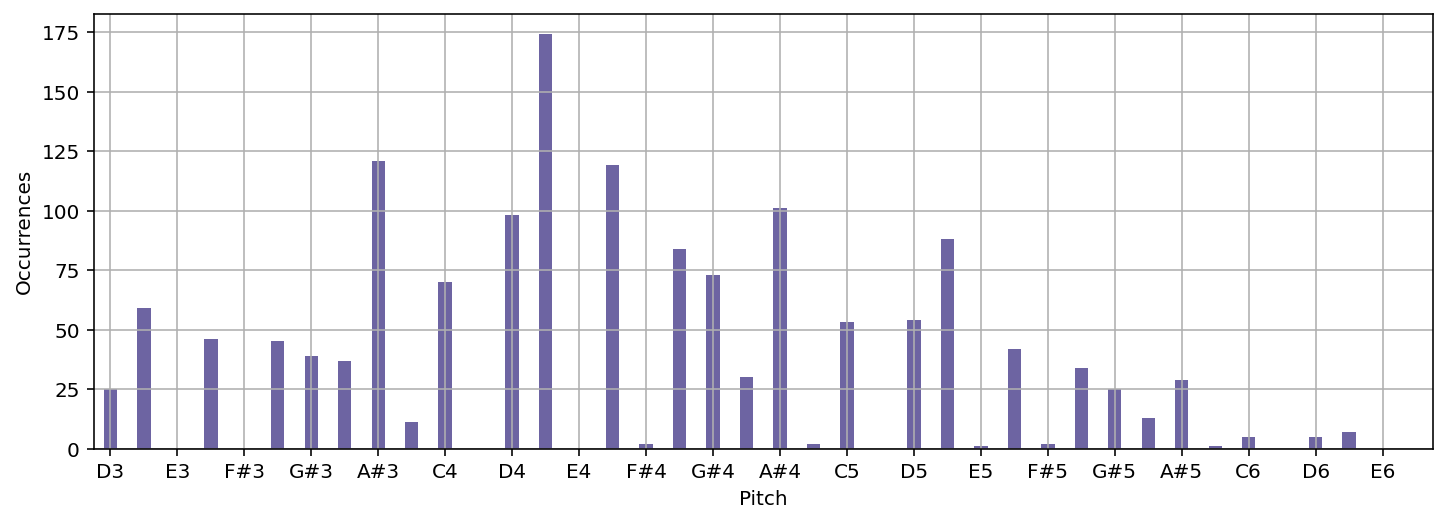

In [11]:
ph = mp.analyse.pitch_histogram(m_df, 
                                do_plot=True, 
                                visulize_midi_range=[50, 90])

# Durch den Zusatz 'visulize_midi_range=[50, 90]' wird der dargestellte Ausschnitt
# auf den Bereich zwischen MIDI-Pitch 50 (= D3) und 90 (= F6) eingegrenzt.

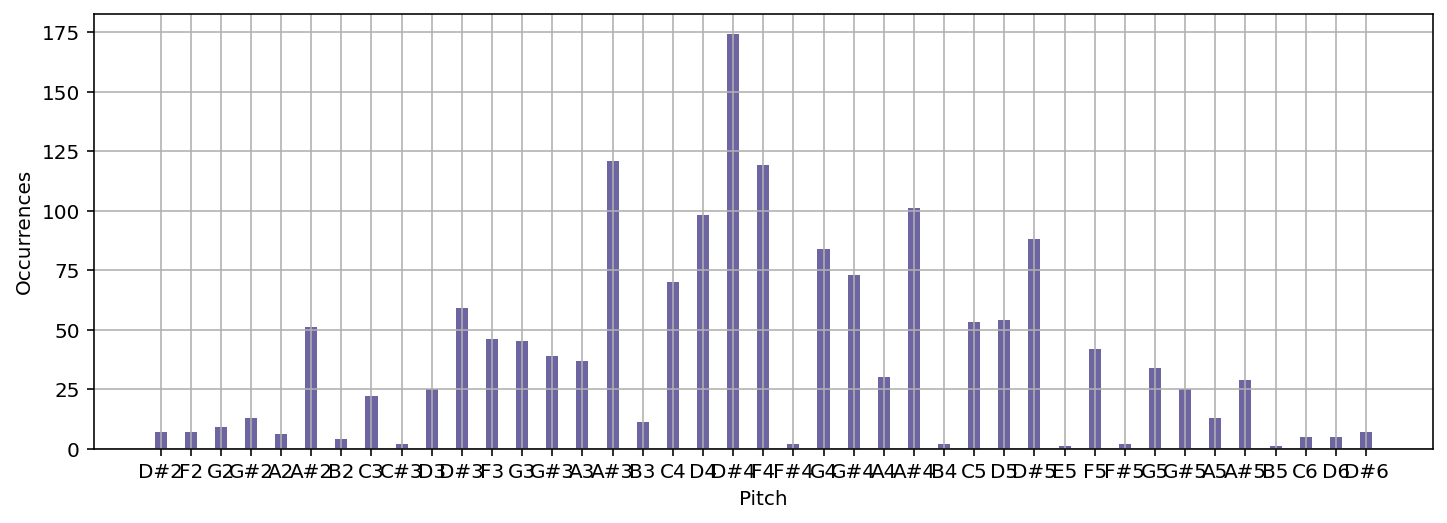

In [12]:
ph2 = mp.analyse.pitch_histogram(m_df,
                                 do_plot=True,
                                 do_plot_full_axis=False)

# Durch den Zusatz 'do_plot_full_axis=False,' werden bei der Grafik 
# nur die Häufigkeiten von Tönen angezeigt, die auch tatsächlich auftauchen. 
# Alle anderen Töne werden auf der x-Achse gelöscht. 

### 2.2 Tonhöhenklassen 

Für harmonische Analysen ist es viel übersichtlicher, nicht die einzelnen Tonhöhen, sondern Tonhöhenklassen ('pitch class') zu ermitteln. 

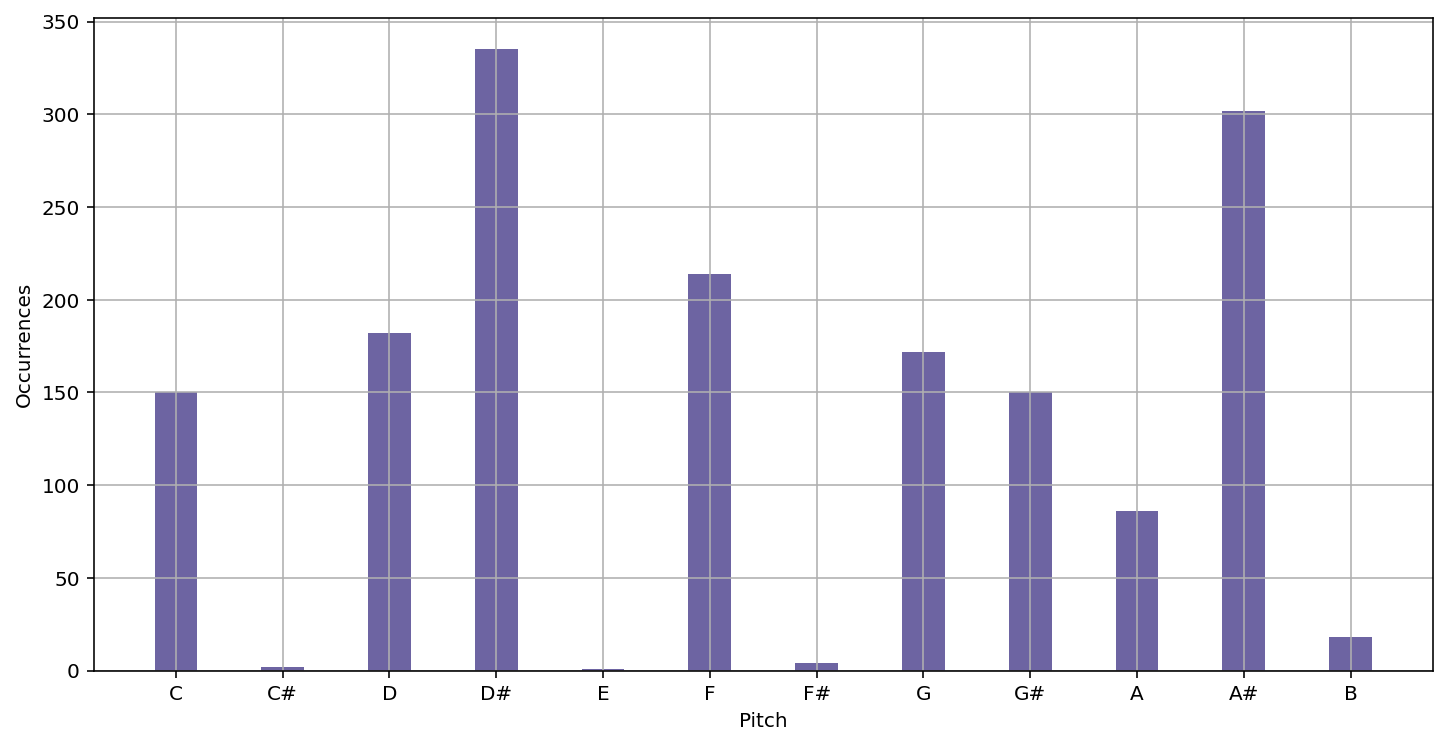

In [13]:
pitchclass_hist = mp.analyse.pitch_class_histogram(m_df, 
                                                   do_plot=True)

Nun ist klar zu erkennen: Mozart verwendet fast ausschließlich die Töne der Es-Dur Tonleiter - mit einer interessanten Ausnahme: Der Tritonus a taucht relativ häufig auf!

Womit könnte dies zusammenhängen? Um diese Frage zu beantworten, müssen Sie natürlich in die Partitur schauen und dort die Verwendungsweisen des Tons a überprüfen. 

In [14]:
# Die Häufigkeitstabelle wird automatisch erzeugt, 
# sobald wir im Befehl den Plot-Parameter ausstellen: 'do_plot=None'.

pitchclass_hist = mp.analyse.pitch_class_histogram(m_df, 
                                                   do_plot=None)

mp.utils.display_table(data=pitchclass_hist, 
                       columns=['Tonhöhenklasse','Häufigkeit'])

# Mit dem zweiten Befehl wird die Tabelle dargestellt und beschriftet. 

Tonhöhenklasse,Häufigkeit
C,150
C#,2
D,182
D#,335
E,1
F,214
F#,4
G,172
G#,150
A,86


In [15]:
# Die Häufigkeiten der Tonhöhenklassen werden mit dem folgenden Befehl als csv-Datei exportiert: 

mp.utils.export_as_csv(data=pitchclass_hist, 
                       columns=['Pitch Class','Occurrences'],
                       save_file_name ='pitch_class_hist.csv', 
                       do_save=False,
                       do_print=None, 
                       sep=';', 
                       header=True)

# (Zu den Parametern vgl. oben, 2.1)

### 2.3 Intervalle im einstimmigen Verlauf

Wie häufig kommen bestimmte Intervallschritte in den einzelnen Stimmen vor? Haben alle Stimmen einen ähnlichen Intervallverlauf – oder gibt es z.B. in den Unterstimmen mehr Sprünge, in der Melodiestimme mehr Schritte?

Schauen wir uns zunächst die Intervallverteilung in der ersten Violine an. 

In [16]:
v = m_df[['PartID','PartName']].drop_duplicates().to_numpy()
print(v)

# Durch diesen Befehl werden zunächst die Stimmen und ihre Bezeichnung angezeigt. 

[['1' 'Violino I']
 ['2' 'Violino II']
 ['3' 'Viola']
 ['4' 'Violoncello']]


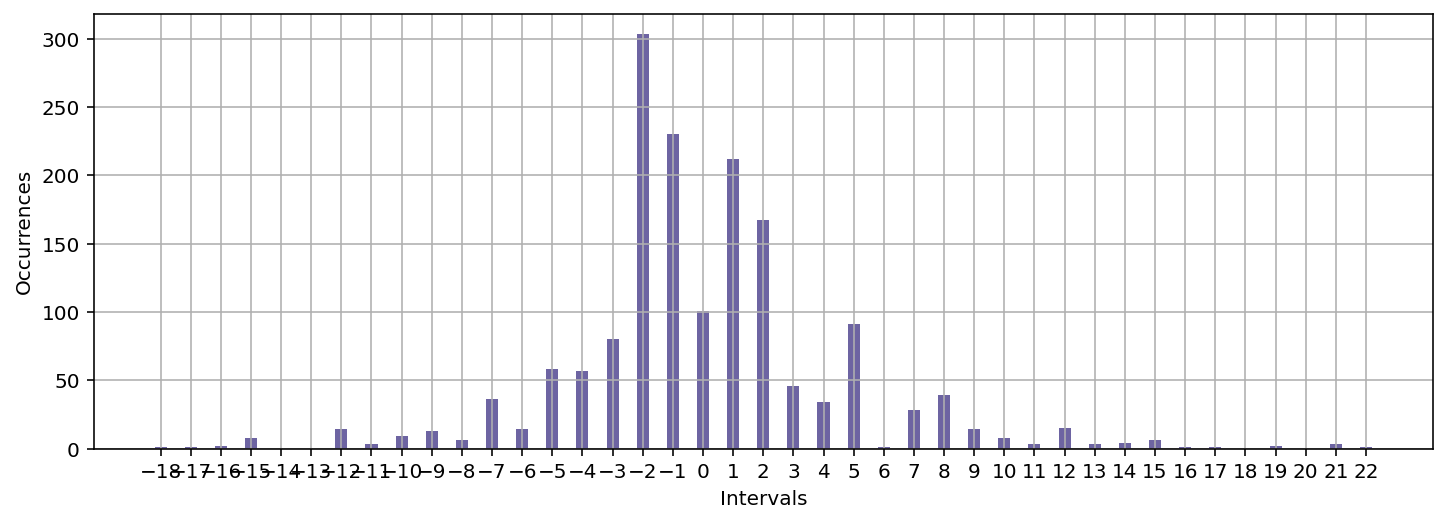

In [17]:
# Nun wählen wir die erste Stimme (mit dem PartID=1) aus: 'part='1' 

interval_hist = mp.analyse.interval(m_df,
                                    part='1',
                                    do_plot=True)

Die erste Violine schreitet vorwiegend in Sekunden, Terzen und Quarten voran, wobei absteigende Schritte häufiger sind als aufsteigende. Größere Intervalle kommen auch vor, sind aber viel seltener. 

In [18]:
# Mit dem folgenden Befehl wird die Verteilung der Intervallhäufigkeiten 
# als Tabelle angezeigt (nur falls 'do_print=True')
# und die Tabelle in die Datei 'interval_1.csv' exportiert (nur falls 'do_save=True').

mp.utils.export_as_csv(data=interval_hist, 
                       columns=['Intervall', 'Häufigkeit'],
                       save_file_name ='interval_1.csv', 
                       do_save=True,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

Intervall,Häufigkeit
-18,1
-17,1
-16,2
-15,8
-12,14
-11,3
-10,9
-9,13
-8,6
-7,36


**Aufgabe**: Wie steht es nun um die Cello-Stimme?  
Dazu müssen Sie an der richtigen Stelle einfach die '1' durch eine '4' ersetzen...

**Tipp**: Kopieren Sie den gesamten Befehl einfach in eine neue Code Cell. 

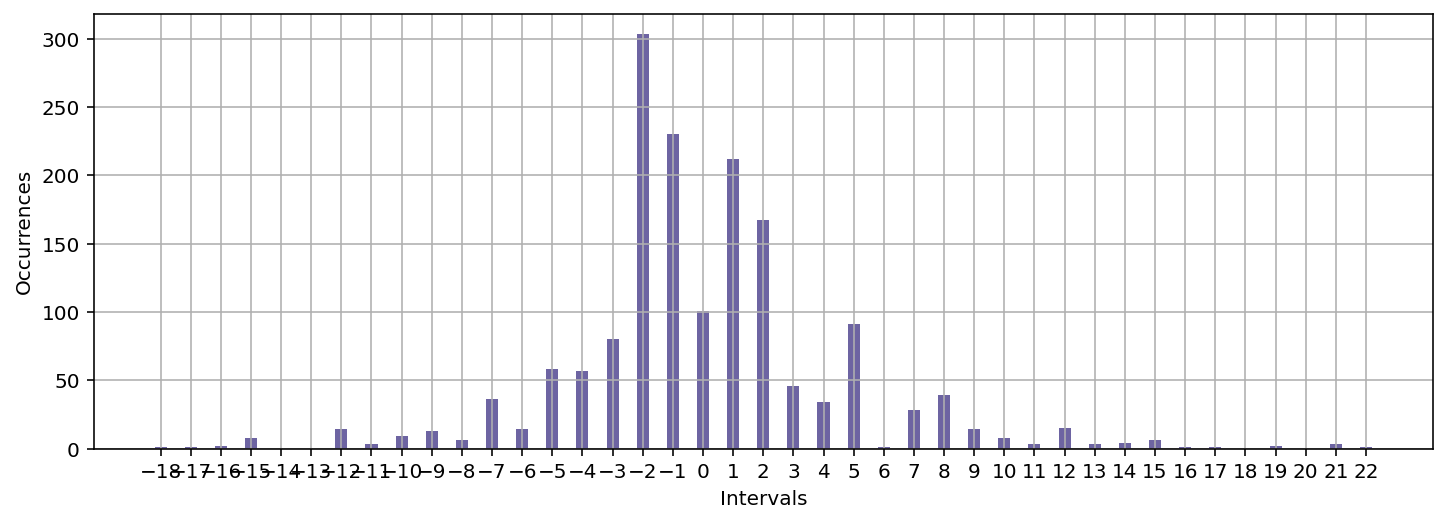

In [19]:
# Hier der angepasste Befehl: 

interval_hist = mp.analyse.interval(m_df,
                                    part='4',
                                    do_plot=True)

### 2.4 Tondauern 

Nun wenden wir uns der rhythmischen Gestaltung zu: Welche Dauernwerte werden in der Komposition verwendet und wie häufig kommen diese jeweils vor?

In der folgenden Auswertung erhält die Viertelnote den Wert 1. Kürzere und längere Notenwerte werden entsprechend als Vielfache bzw. Teiler von 1 benannt. 

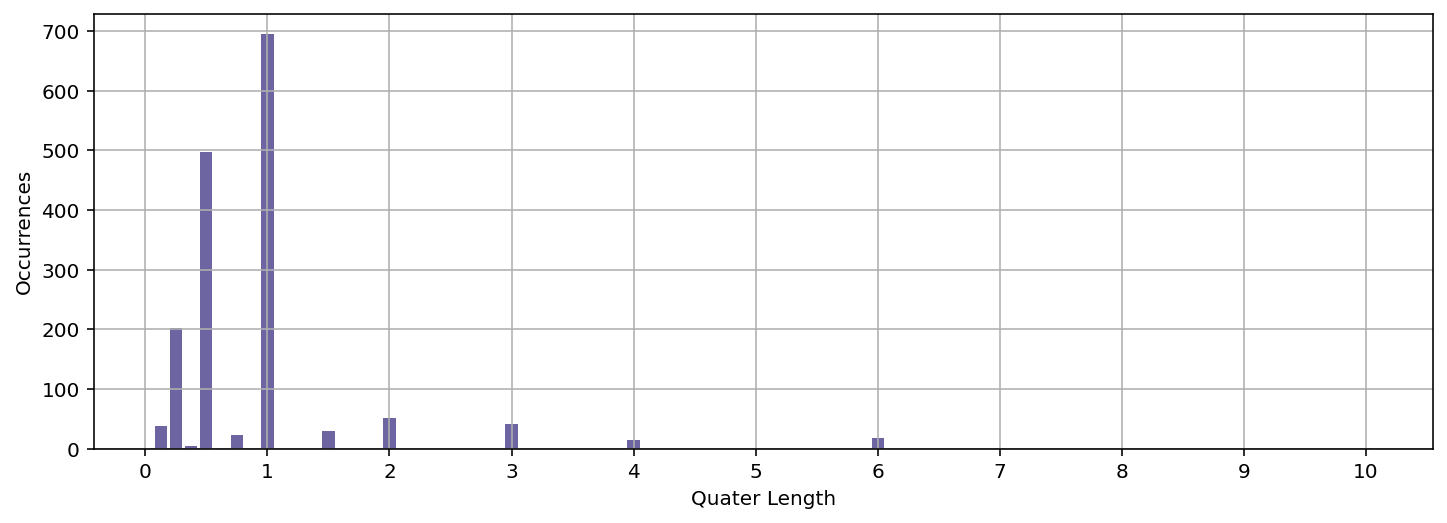

In [20]:
quarter_dur_hist = mp.analyse.quarterlength_duration_histogram(m_df,
                                                               do_plot=True)

Wie erwartet verwendet Mozart vorwiegend Viertelnoten und kleinere Notenwerte, es kommen aber auch ein paar längere Noten vor. Wenn wir die jeweilige Anzahl genau wissen wollen, müssen wir uns die Häufigkeitstabelle anzeigen lassen: 

In [21]:
quarter_dur_hist = mp.analyse.quarterlength_duration_histogram(m_df,
                                                               do_plot=False)
# Bei 'do_plot=False' wird nur die Tabelle angezeigt. 
# Die Tabelle wird durch den folgenden Befehl erzeugt und beschriftet:

mp.utils.display_table(data=quarter_dur_hist, 
                       columns=['Dauernklasse','Häufigkeit'])

Dauernklasse,Häufigkeit
0.12,38
0.25,202
0.38,4
0.50,497
0.75,22
1.00,694
1.50,30
2.00,51
3.00,42
4.00,15


In [22]:
# Hier noch der Befehl zum Abspeichern der Tabelle: 

mp.utils.export_as_csv(data=quarter_dur_hist, 
                       columns=['Dauernwerte', 'Häufigkeiten'],
                       save_file_name ='quarter_duration_hist.csv', 
                       do_save=False,         
                       do_print=False, 
                       sep=';', 
                       index=False, 
                       header=True)

### 2.5 Metrisches Profil 

Wie deutlich wird das Metrum in den einzelnen Stimmen einer Komposition artikuliert – durch die Platzierung der Töne auf Taktanfängen und den metrisch wichtigen Positionen innerhalb des Taktes (z.B. der Taktmitte oder auf den Viertelpositionen)? Hierzu lässt sich in eine Liste der Häufigkeiten von Tönen auf den verschiedenen metrischen Positionen in den einzelnen Stimmen anzeigen. 

Ein solches Profil hat natürlich zur Voraussetzung, dass das untersuchte Stück in einem einzigen Metrum steht und keine Taktwechsel hat. Das überprüft man mit dem folgenden Befehl: 

In [23]:
ts_hist = mp.analyse.time_signature_histogram(m_df,
                                              do_plot=False)

mp.utils.display_table(data=ts_hist, 
                       columns=['Taktart', 'Anzahl'])

Taktart,Anzahl
4/4,31
3/4,128


Es tauchen also sowohl 4/4-Takte als auch 3/4-Takte in dem Stück auf, wobei der 3/4-Takt sogar überwiegt - obwohl das Stück ja im 4/4-Takt beginnt. Mit dem folgenden Befehl werden daher zwei unterschiedliche metrische Profile erzeugt - einmal für die 4/4-Takte, einmal für die 3/4-Takte. 

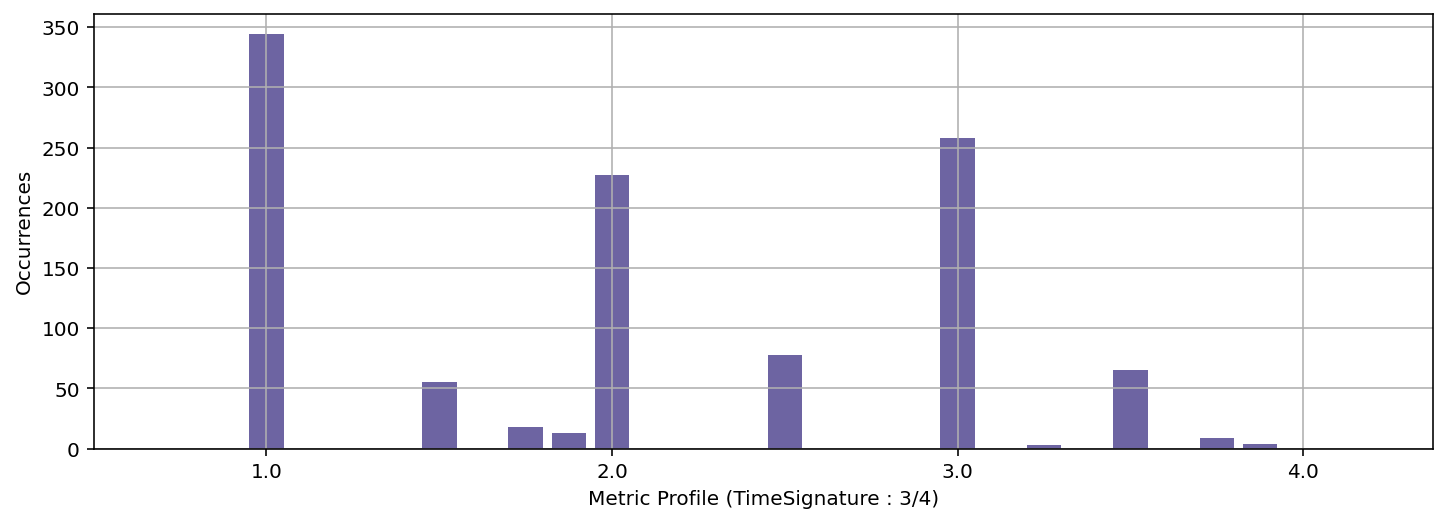

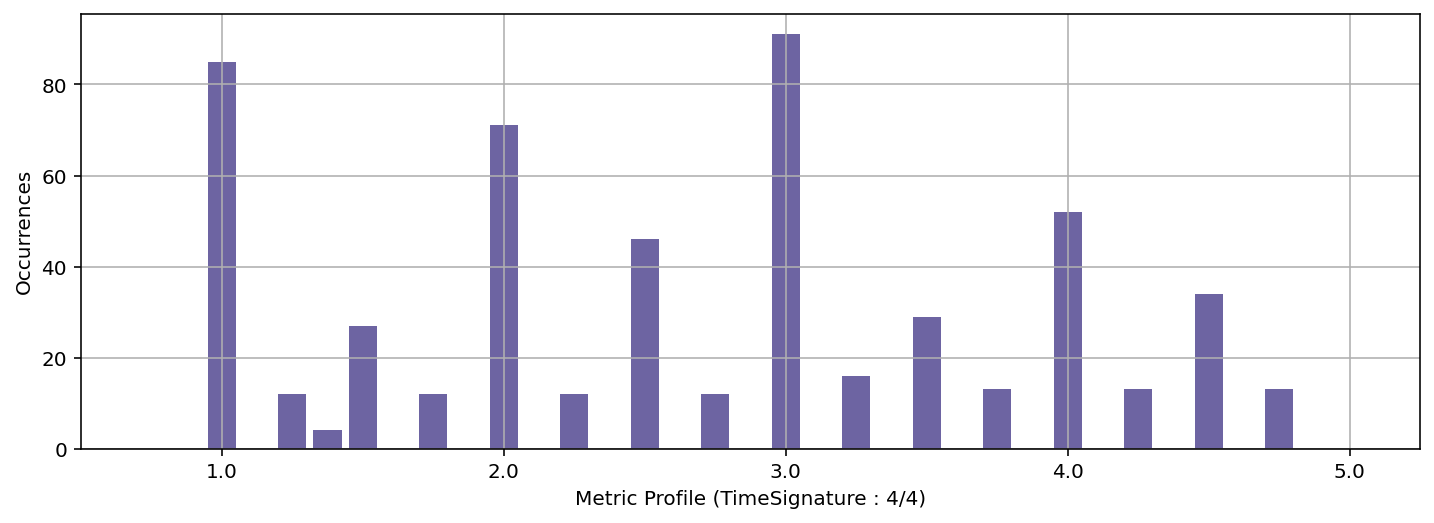

In [24]:
mp_ts_dict = mp.analyse.metric_profile_split_time_signature(m_df, 
                                                              do_plot=True)

<font color='red'>Done</font> 

@ Christon: Please add the codes for printing the list (one list for each metric) with the metric points in rows. Plus the code for saving the tables!!



In [25]:
for k in mp_ts_dict.keys():
    print(f"Time Signature {k}")
    saveas = 'metric_profile_'+k.replace('/','-')+'.csv'
    mp.utils.export_as_csv(data=mp_ts_dict[k], 
                           columns=['Interval', 'Occurrences'],
                           save_file_name =saveas, 
                           do_save=False,
                                   do_print=True, 
                                   do_return_pd=False,
                                   sep=';', 
                                   index=False, 
                                   header=True)



Time Signature 3/4


Interval,Occurrences
1,344
1,55
1,18
1,13
2,227
2,78
3,258
3,3
3,65
3,9


Time Signature 4/4


Interval,Occurrences
1,85
1,12
1,4
1,27
1,12
2,71
2,12
2,46
2,12
3,91


### 3. Zweidimensionale Häufigkeitsverteilungen

Wir haben uns bereits die Häufigkeiten von Tonhöhen bzw. Tonhöhenklassen angeschaut. Nun könnte man sagen: Längere Töne haben natürlich mehr Gewicht als kurze Töne oder Töne zwischen den Zählzeiten. Diesen Gedanken können wir weiterverfolgen, indem wir uns kombinierte, ‚doppelte‘ oder ‚bivariate‘ Häufigkeitsverteilungen: Also z.B. die Häufigkeiten der Tonhöhen für jeweils die verschiedenen Dauernwerte oder die Häufigkeiten der Tonhöhenklasse jeweils für die verschiedenen metrischen Positionen. Hierum soll es im Folgenden anhand von zwei Beispielen gehen.  

Beispiel 1: Dauern pro Tonhöhenklassen.
Gibt es Unterschiede bei den Dauernwerten bzgl. der verschiedenen Tonhöhenklassen?

Beispiel 2: Tonhöhen auf metrischen Positionen
Gibt es Unterschiede bei den Dauernwerten bzgl. der verschiedenen Tonhöhenklassen?

### 3.1 Dauernwerte pro Tonhöhenklassen

<font color='red'> Changes : mp.analyse.quarterlength_duration_histogram 2D

the function mp.analyse.quarterlength_duration_histogram() has following arguments:<br>
plot_with(str): accepts three paramters: 'PitchClass', 'Pitch' and None
<br>
None will plot -> 2d plot
<br>
Pitch and PitchClass -> 3d plot</font> 
<br>
<br>

<br>


<font color='red'> 2D</font> 

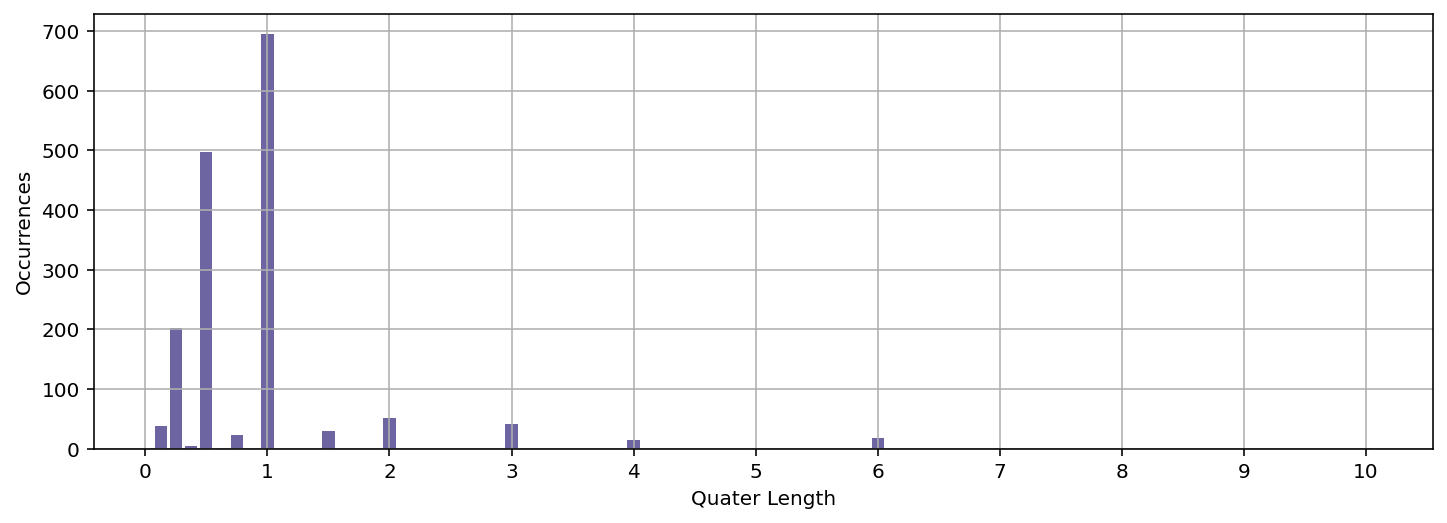

Quater Length,Occurrences
0.12,38
0.25,202
0.38,4
0.50,497
0.75,22
1.00,694
1.50,30
2.00,51
3.00,42
4.00,15


In [26]:
dur_hist = mp.analyse.quarterlength_duration_histogram(m_df,
                                                       plot_with=None,
                                                       do_plot=True)
mp.utils.export_as_csv(data=dur_hist,
                           columns=['Quater Length', 'Occurrences'],
                           save_file_name='QuaterLength.csv',
                           do_save=False,
                           do_print=True,
                           do_return_pd=False,
                           sep=';',
                           index=False,
                           header=True)



# Durch die Parameter 'with_pitch=True' und 'with_pitchclass=False' 
# wird stattdessen eine 3D-Grafik der Tonhöhen pro Dauernklasse angezeigt. 


Tipp: Da die CD-Grafik im Browser sehr klein ist, empfiehlt es sich auch hier, sie in einem externen Fenster zu öffnen. Dies geschieht, indem der Befehl '%matplotlib' vorangestellt wird. Die Grafik öffnet sich dann in einem Pop-Up-Fenster und kann vergrößert und mit der Mouse beliebig gedreht werden! 

<font color='red'> 3D plot - With PitchClass </font> 

Using matplotlib backend: MacOSX


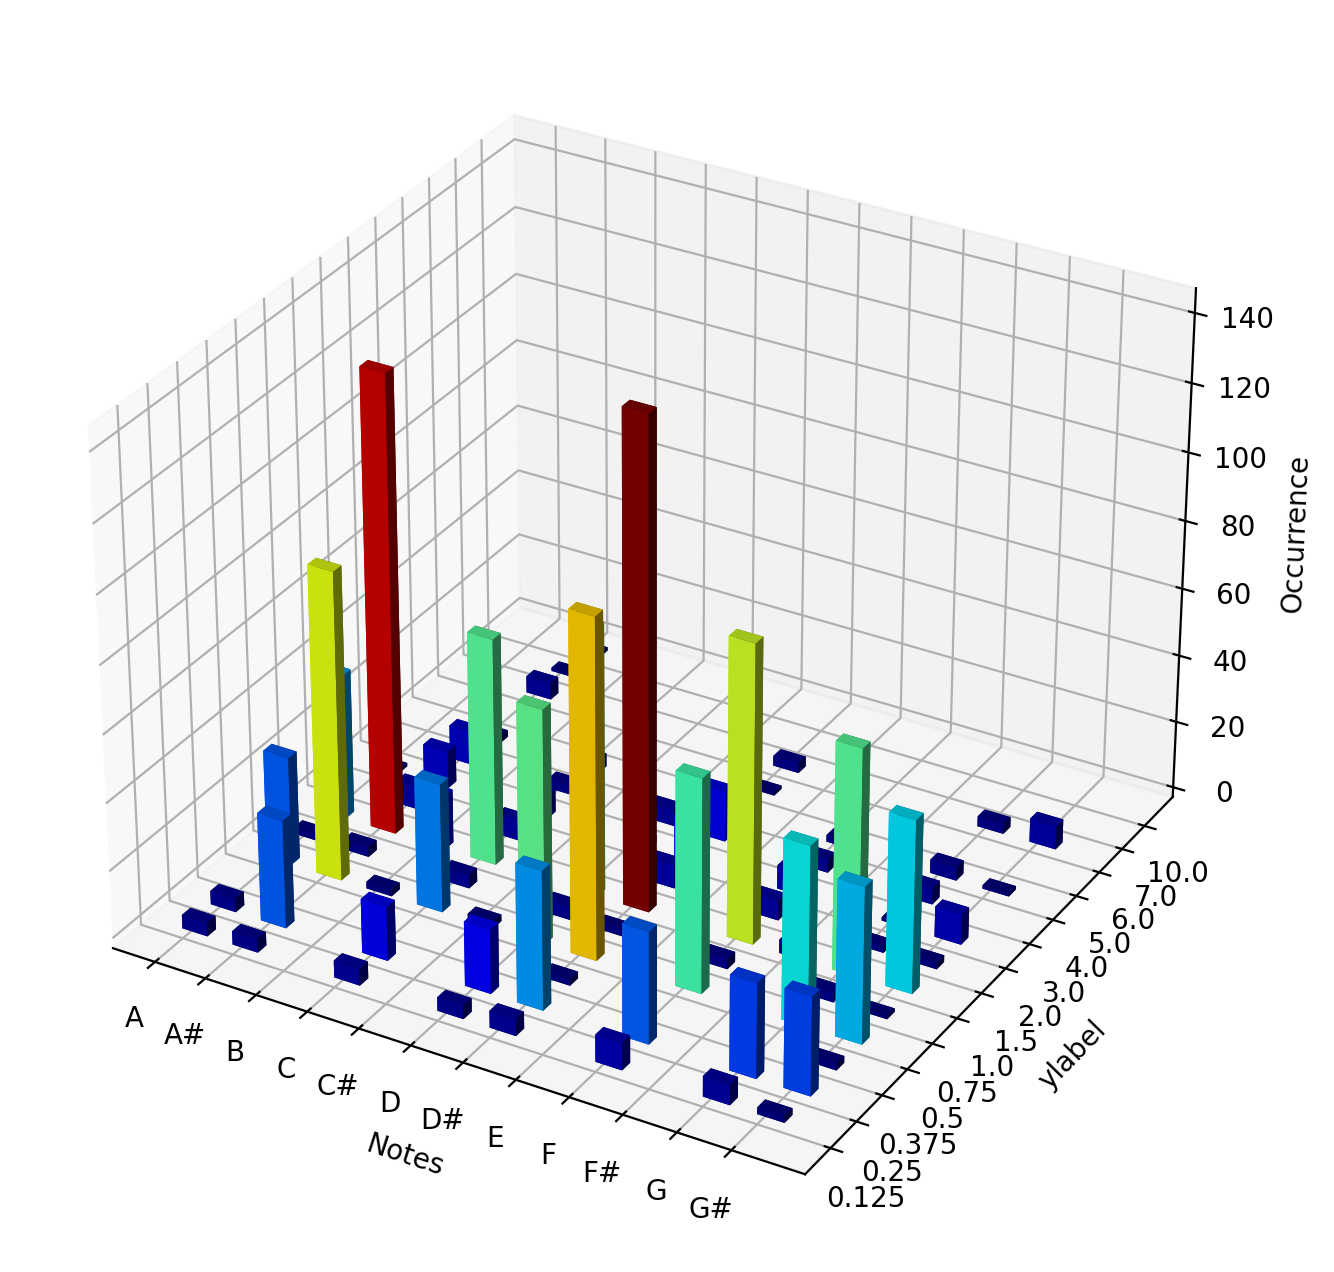

In [27]:
%matplotlib

dur_pc_hist = mp.analyse.quarterlength_duration_histogram(m_df,
                                                          plot_with='PitchClass',
                                                          do_plot=True)

In [28]:

mp.utils.export_as_csv(data=dur_pc_hist,
                           columns=['Pitch','Quater Length', 'Occurrences'],
                           save_file_name='QuaterLength.csv',
                           do_save=False,
                           do_print=True,
                           do_return_pd=False,
                           sep=';',
                           index=False,
                           header=True)

Pitch,Quater Length,Occurrences
A,0.125,4
A,0.25,4
A,0.5,32
A,0.75,2
A,1.0,43
A,2.0,1
A#,0.125,4
A#,0.25,32
A#,0.5,91
A#,0.75,3


Um diese Funktion bei folgenden Grafiken wieder auszuschalten, muss der Befehl '%matplotlib inline' ausgeführt werden: 

<font color='red'> 3D plot - With Pitch </font> 

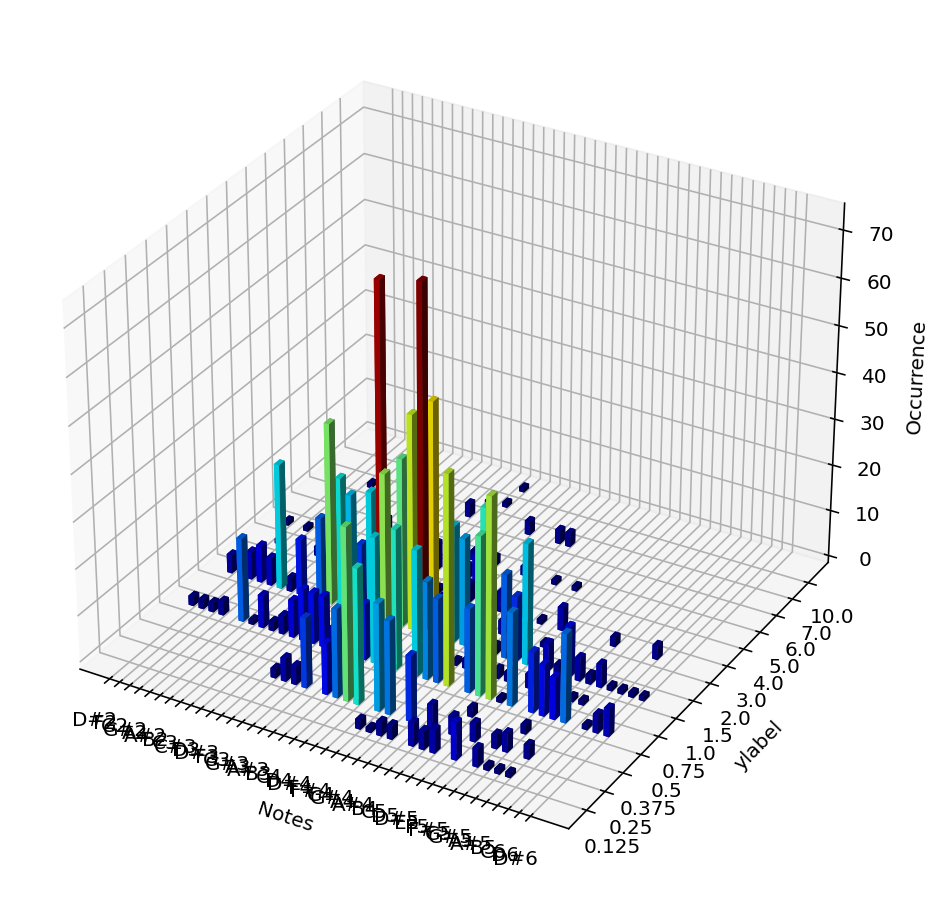

In [29]:
%matplotlib inline

#%matplotlib

dur_p_hist = mp.analyse.quarterlength_duration_histogram(m_df,
                                                          plot_with='Pitch',
                                                          do_plot=True)

<font color='red'> Done </font> 

@ Christon: Please add the list/table and save function!!

In [30]:
mp.utils.export_as_csv(data=dur_p_hist,
                           columns=['Pitch','Quater Length', 'Occurrences'],
                           save_file_name='QuaterLength.csv',
                           do_save=False,
                           do_print=True,
                           do_return_pd=False,
                           sep=';',
                           index=False,
                           header=True)

Pitch,Quater Length,Occurrences
D#2,0.5,2
D#2,1.0,4
D#2,3.0,1
F2,0.5,2
F2,1.0,4
F2,2.0,1
G2,0.5,2
G2,1.0,6
G2,3.0,1
G#2,0.5,3


### 3.2 Metrische Positionen der Tonhöhenklassen

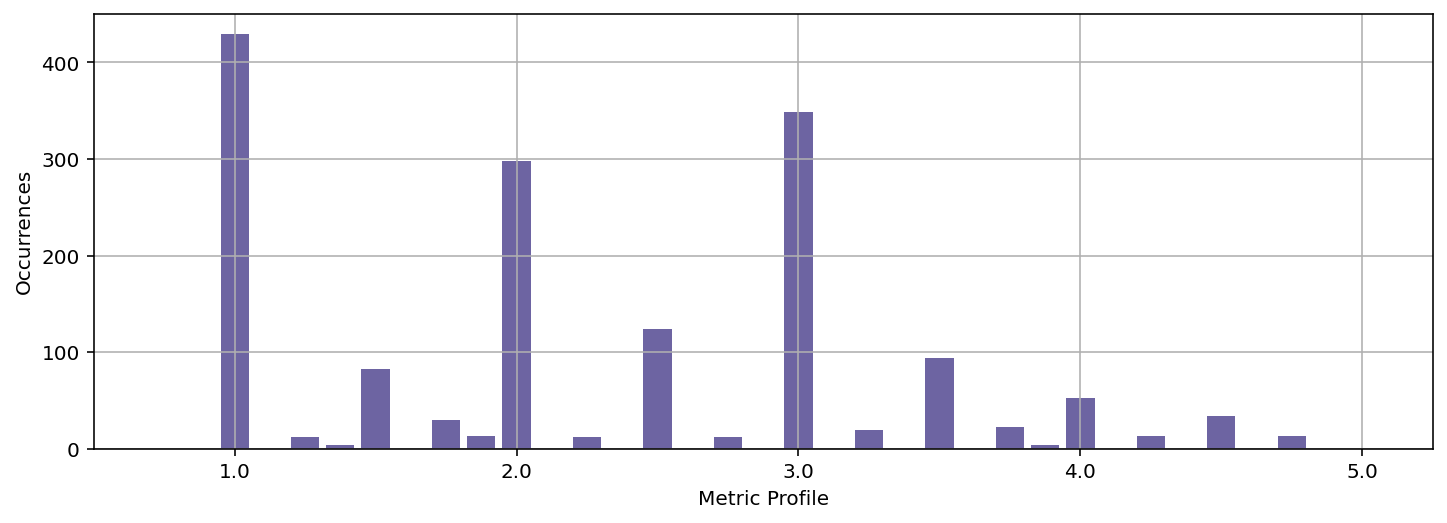

In [31]:
mp_hist = mp.analyse.metric_profile(m_df, plot_with=None, do_plot=True)

In [32]:
mp.utils.export_as_csv(data=mp_hist, 
                       columns=['Metric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

Metric Profile,Occurrences
1,429
1,12
1,4
1,82
1,30
1,13
2,298
2,12
2,124
2,12


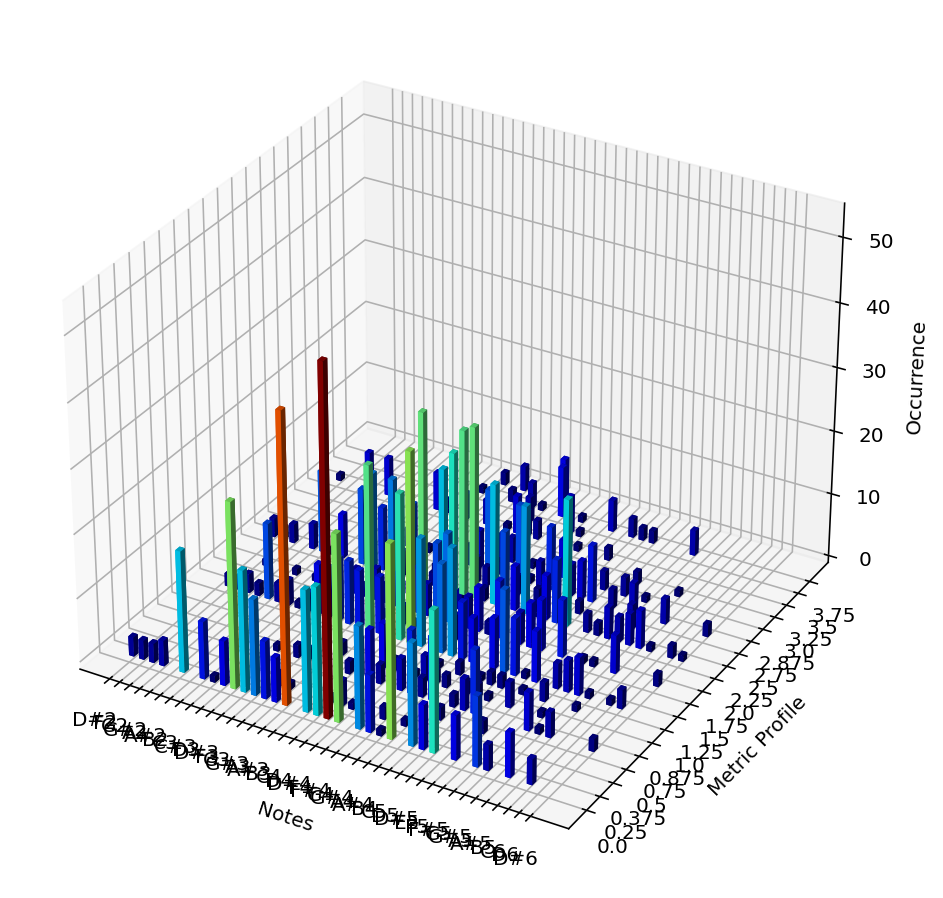

In [33]:
mp_p_hist = mp.analyse.metric_profile(m_df, plot_with='Pitch', do_plot=True)

In [34]:
mp.utils.export_as_csv(data=mp_p_hist, 
                       columns=['MIDI', 'Pitch','Metric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

MIDI,Pitch,Metric Profile,Occurrences
39,D#2,0.0,3
39,D#2,2.0,3
39,D#2,3.0,1
41,F2,0.0,3
41,F2,1.0,2
41,F2,2.0,2
43,G2,0.0,3
43,G2,1.0,2
43,G2,1.5,1
43,G2,2.0,3


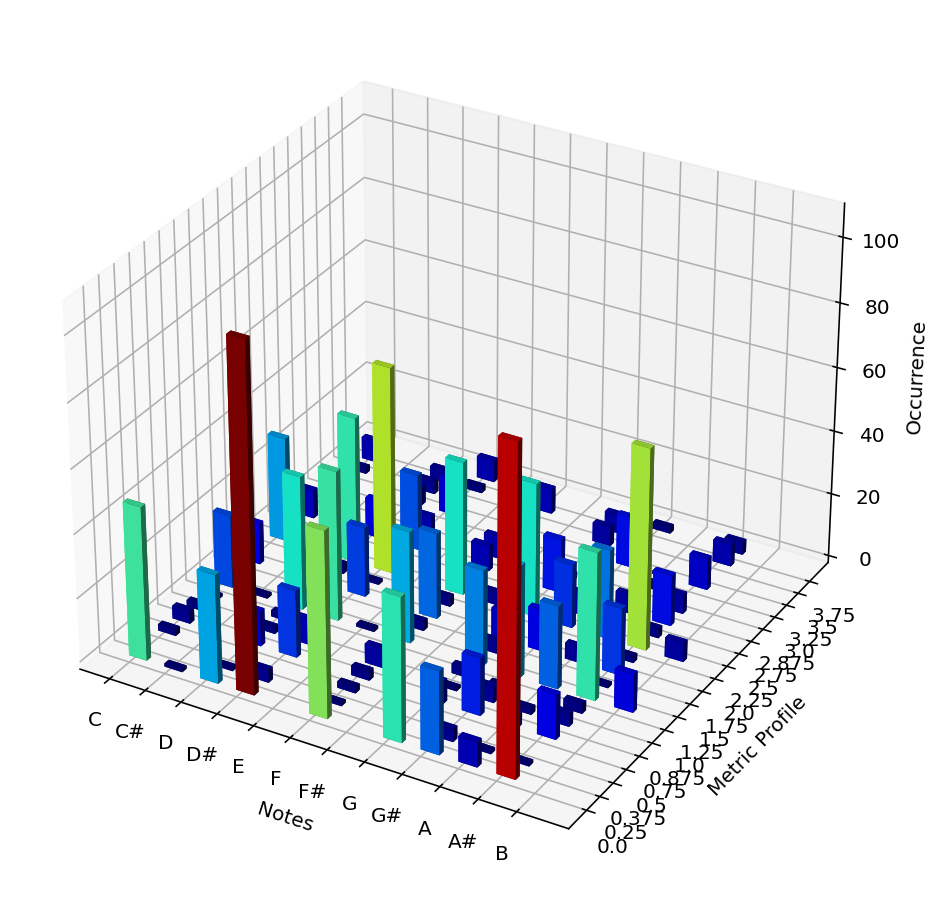

In [35]:
mp_pc_hist = mp.analyse.metric_profile(m_df, plot_with='PitchClass', do_plot=True)

In [36]:
mp.utils.export_as_csv(data=mp_pc_hist, 
                       columns=['Pitch','Metric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

Pitch,Metric Profile,Occurrences
C,0.0,48
C,0.375,2
C,0.5,4
C,0.75,2
C,0.875,1
C,1.0,23
C,1.25,3
C,1.5,13
C,2.0,33
C,2.5,9


<font color='red'>  DONE </font> 
@ Christon: Please add the function 'with_pitchclass=True'; also with list/table and export/save!

Auch hier ist es sinnvoll, sich die Grafik im externen Pop-Up-Fenster von Matplotlib anzuschauen. 

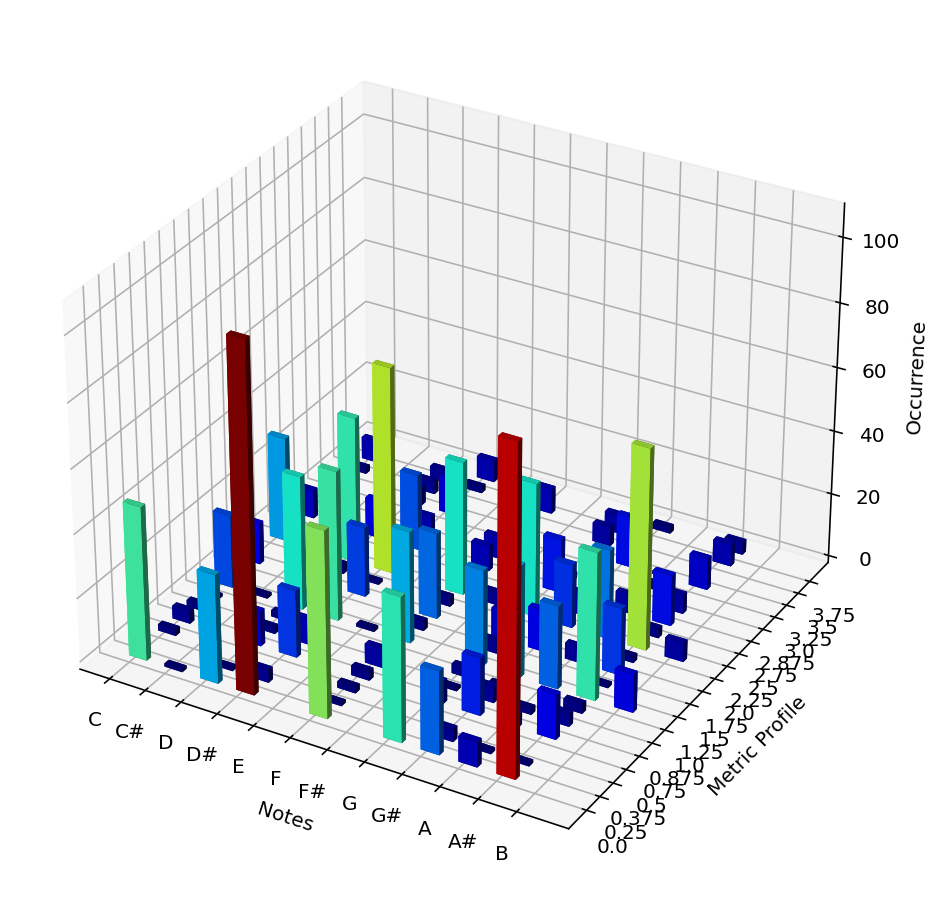

In [37]:
# %matplotlib 
mp_pc_hist = mp.analyse.metric_profile(m_df, plot_with='PitchClass', do_plot=True)

In [38]:
# Und der Befehl für die Ansicht als Liste ('do_print=True') 
# und für den Datenexport ('do_save=True'): 

mp.utils.export_as_csv(data=mp_pc_hist, 
                       columns=['Tonhöhe', 'Metrische Position', 'Anzahl'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=True,
                       do_print=True, 
                       sep=';', 
                       index=False, 
                       header=True)

Tonhöhe,Metrische Position,Anzahl
C,0.0,48
C,0.375,2
C,0.5,4
C,0.75,2
C,0.875,1
C,1.0,23
C,1.25,3
C,1.5,13
C,2.0,33
C,2.5,9


Allerdings haben wir jetzt einen Fehler gemacht: Der Mozart-Satz hat ja einen Taktwechsel!!
Wir haben in unserer Auswertun jedoch nicht zwischen 4/4-Takt und 3/4-Takt unterschieden. Daher müssen wir alle Befehle nochmals wiederholen, nachdem wir in die beiden Takttypen unterschieden haben. 

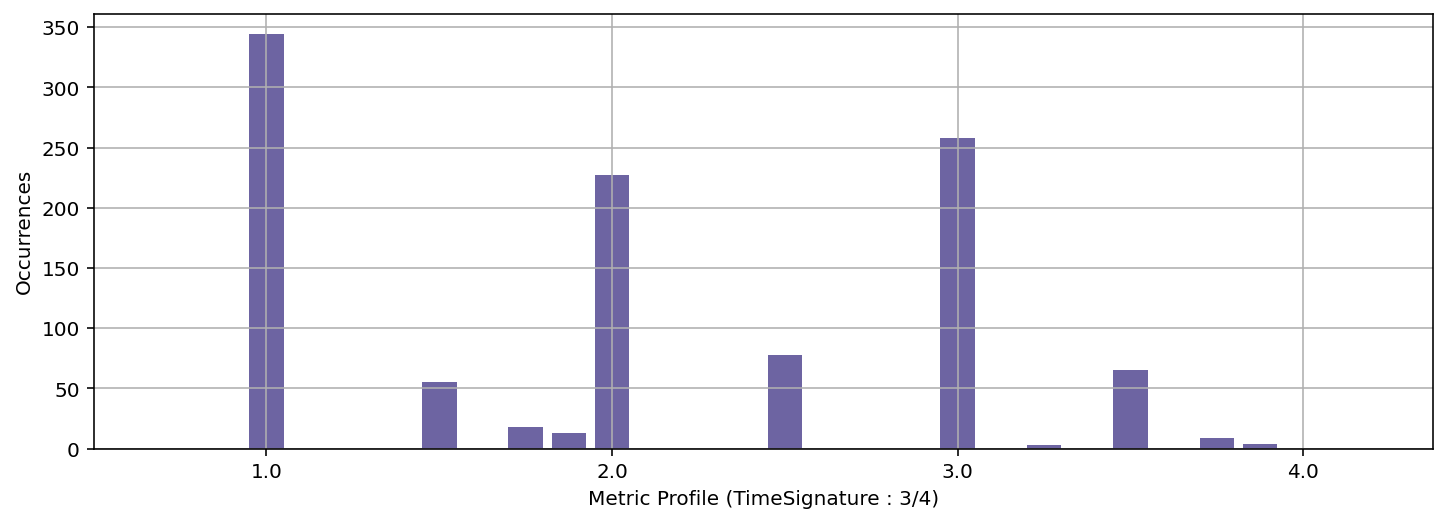

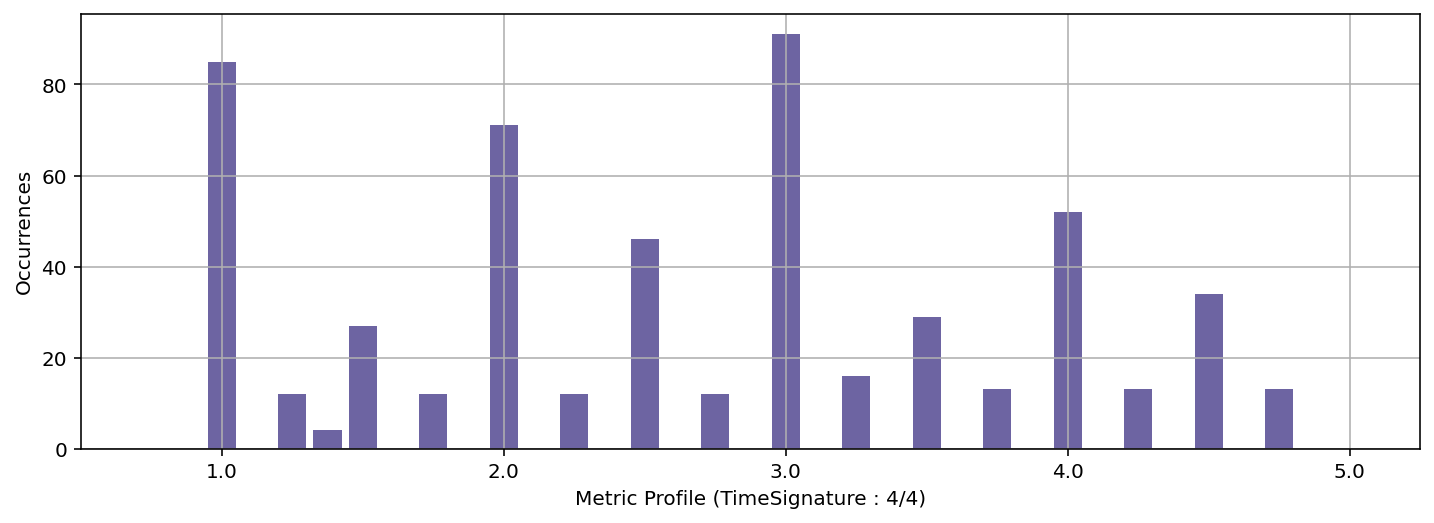

In [39]:
# Hier der Befehl zur Unterscheidung der Takttypen: 
# In direktem Anschluss werden die Tonhöhen-Dauern-Profile getrennt dargestellt: 

mp_ts_dict_2d = mp.analyse.metric_profile_split_time_signature(m_df, plot_with=None, do_plot=True)




@ Christon: Again, more important (and easier to conceive) are *pitchclasses* - not pitches! 

In [42]:
for k2 in mp_ts_dict_2d.keys():
    print(f"Time Signature {k2}")
    saveas = 'metric_profile_ts_'+k2.replace('/','-')+'.csv'

    mp.utils.export_as_csv(data=mp_ts_dict_2d[k2], 
                       columns=['PMetric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

Time Signature 3/4


ValueError: 3 columns passed, passed data had 2 columns

In [ ]:
mp_ts_dict_p = mp.analyse.metric_profile_split_time_signature(m_df, plot_with='Pitch', do_plot=True)

for k2p in mp_ts_dict_p.keys():
    print(f"Time Signature {k2p}")
    saveas = 'metric_profile_ts_p_'+k2p.replace('/','-')+'.csv'

    mp.utils.export_as_csv(data=mp_ts_dict_p[k2p], 
                       columns=['MIDI', 'Pitch','Metric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)


In [ ]:
mp_ts_dict_pc = mp.analyse.metric_profile_split_time_signature(m_df, plot_with='PitchClass', do_plot=True)

for k2pc in mp_ts_dict_p.keys():
    print(f"Time Signature {k2pc}")
    saveas = 'metric_profile_ts_pc_'+k2p.replace('/','-')+'.csv'

    mp.utils.export_as_csv(data=mp_ts_dict_pc[k2pc], 
                       columns=['MIDI', 'Pitch','Metric Profile','Occurrences'],
                       save_file_name ='metric_profile_hist.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)



@ Christon: Right here, there should be two lists - one for 4/4 and one for 3/4; please add export function, too!

### 4. Anwendung von Takt- und Stimmenfilter

Alle statistischen Abfragen lassen sich durch eine einfach zu bedienende Filterfunktion auf beliebige Ausschnitte und Stimmen eingrenzen. Dazu muss man nur die entsprechenden Taktangaben und Stimmenbezeichnungen eingeben. 

Hier zwei Beispiele: 

1. Mit den folgenden Befehlen lässt sich eine kombinierte Liste der Intervallhäufigkeiten der beiden Violinenstimmen ('PartID':'1-2') für die ersten fünf Takte ('Measure':'1-5') anzeigen, exportieren bzw. als Histogramm anzeigen.
Diese Auswahl lässt sich beliebig verändern! 

In [ ]:
filter_dict_interval ={'PartID':'1-2', 'Measure':'1-5'}
interval_hist_example = mp.analyse.interval(m_df,
                                    do_plot=True, 
                                    filter_dict = filter_dict_interval)

mp.utils.export_as_csv(data=interval_hist_example, 
                       columns=['Intervall', 'Häufigkeit'],
                       save_file_name ='interval.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

2. Mit den folgenden Befehlen lässt sich eine Liste der Tonhöhenklassen der Cellostimme ('PartID':'4') für die ersten zehn Takte ('Measure':'1-10') anzeigen, exportieren bzw. als Histogramm anzeigen.
Auch diese Auswahl lässt sich beliebig verändern! 

In [ ]:
filter_dict_cello ={'PartID':'4', 'Measure':'1-10'}

pitchclass_hist_cello = mp.analyse.pitch_class_histogram(m_df, 
                                                         do_plot=True,
                                                         filter_dict = filter_dict_cello)

mp.utils.export_as_csv(data=pitchclass_hist_cello, 
                       columns=['Tonhöhenklasse', 'Häufigkeit'],
                       save_file_name ='cello.csv', 
                       do_save=False,
                       do_print=True, 
                       do_return_pd=False,
                       sep=';', 
                       index=False, 
                       header=True)

@ Egor and Christon: Here something strange is happening. If I raise the measure to '1-15' (or more than 15 bars), there's an error message! WHY???

### 5. Aufgaben

Wir haben uns die Ergebnisse bislang nur anhand eines einzigen Stückes angeschaut. Wie stellt sich nun aber die Lage dar, wenn wir mehrere Stücke, z.B. mehrere oder alle Sätze der Komposition, miteinander – und mit anderen Stücken – vergleichen? Gibt es stilistische Regelmäßigkeiten – oder überwiegen die Unterschiede?

Wählen Sie Kompositionen Ihrer Wahl (verschiedene Gattungen, Komponisten und Epochen) und vergleichen Sie diese Stücke hinsichtlich der Häufigkeiten von Tonhöhen, Tonhöhenklassen, Notenwerten und Intervallen miteinander. Interpretieren Sie die Ergebnisse jeweils mit Blick auf den Notentex!